## Import

In [837]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import random
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


## Hyperparameter setting

In [838]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'SEED':41
}

## Fixed RandomSeed

In [839]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

## Data Load

In [840]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [841]:
test=test.drop('ID',axis=1)
train=train.drop('ID',axis=1)

## Data Preprocessing
#### 1. 결측치 처리
#### 2. Train / Validation 분할
#### 3. Data label-encoding, scaling

In [842]:
from pandas.core.reshape.reshape import get_dummies
temp=get_dummies(train['COMPONENT_ARBITRARY'])
train=pd.concat([temp,train],axis=1)
train=train.drop('COMPONENT_ARBITRARY',axis=1)

temp=get_dummies(test['COMPONENT_ARBITRARY'])
test=pd.concat([temp,test],axis=1)
test=test.drop('COMPONENT_ARBITRARY',axis=1)

In [843]:
'''percent20UP = list(train_info[train_info['nullPCT'] >= 20.0]['dataFeatures'])
train = train.drop(percent20UP,axis=1)'''

"percent20UP = list(train_info[train_info['nullPCT'] >= 20.0]['dataFeatures'])\ntrain = train.drop(percent20UP,axis=1)"

In [844]:
categorical_features = ['COMPONENT1','COMPONENT2','COMPONENT3','COMPONENT4','YEAR','MVI','LVI','HVI','VHVI','UHVI']#'YEAR',,''vi_classification
#categorical_features = ['YEAR']

# Inference(실제 진단 환경)에 사용하는 컬럼

#categorical_features = ['YEAR']

# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT1','COMPONENT2','COMPONENT3','COMPONENT4', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']



In [845]:

#train=train.drop(['V40'],axis=1)

#test=test.drop(['V40'],axis=1)


In [846]:
train['V100'] = train['V100'].fillna(0)
#train['V100'] = train['V100'].fillna(0)
#train = train.fillna(train.mean()['V100'])
#train = train.fillna(train.mean())
train = train.fillna(0)
test = test.fillna(0)

In [847]:
train['FUEL']=train['FUEL']*10000
train['SOOTPERCENTAGE']=train['SOOTPERCENTAGE']*10000
#FUEL,SOOTPERCENTAGE
#% to ppm



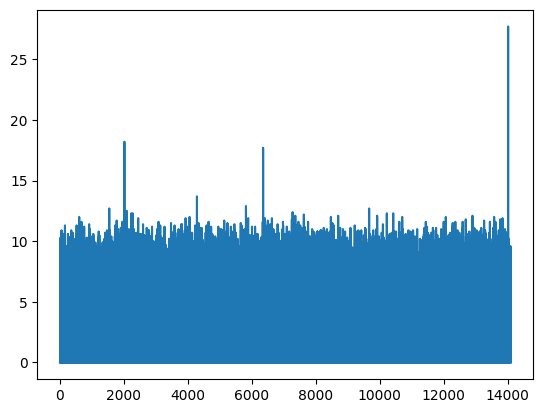

In [848]:
plt.plot(train['FTBN'])

In [849]:

train[(train['P']*0.0001)<0.03]

,COMPONENT1,COMPONENT2,COMPONENT3,COMPONENT4,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
11,0,0,1,0,1172,2018,5,375,0,3,...,0.0,0.0,0.0,0.0,0.0,0,0.0,173.8,4,0
21,0,0,1,0,2896,2014,32,200,0,2,...,0.0,0.0,0.0,0.0,0.0,0,0.0,153.5,48,0
27,0,1,0,0,1706,2012,7,200,0,2,...,62.0,134.0,478.0,9765.0,24308.0,0,0.0,45.8,428,0
29,0,0,1,0,7671,2017,4,571,0,2,...,0.0,0.0,0.0,0.0,0.0,0,0.0,145.9,17,0
38,0,0,1,0,3601,2012,4,200,0,2,...,0.0,0.0,0.0,0.0,0.0,0,0.0,153.6,117,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14069,0,0,1,0,3692,2009,2,200,1,6,...,0.0,0.0,0.0,0.0,0.0,0,0.0,183.1,22,0
14070,0,0,1,0,1315,2020,4,515,0,2,...,0.0,0.0,0.0,0.0,0.0,0,0.0,146.9,11,0
14074,0,0,1,0,2054,2008,21,1250,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,139.7,34,0
14078,0,0,1,0,7021,2013,7,200,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,148.6,17,0


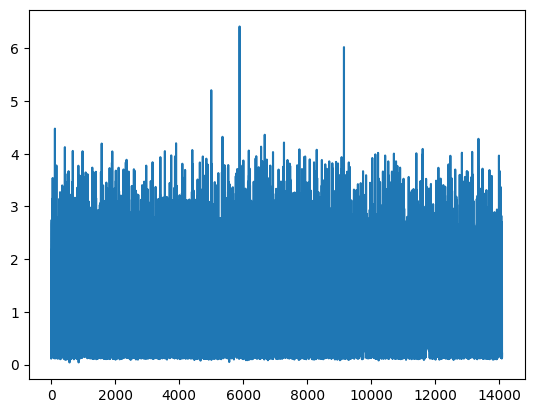

In [850]:
plt.plot(train['S']*0.0001)

In [851]:
def ACEA_group(df):
    s=(df['S']*0.0001).tolist()
    p=(df['P']*0.0001).tolist()
    tbn=df['FTBN'].tolist()
    result=[]
    for i in range(len(s)):
        if s[i]<=0.2:
            if p[i]<=0.05:
                if tbn[i]< 6:
                    result.append('C1')
        elif s[i]<=0.3:
            if (p[i]>=0.07 and p[i]<=0.09):
                if tbn[i]<6:
                    result.append('C2')
        elif s[i]<=0.3:
            if (p[i]>=0.07 and p[i]<=0.09):
                result.append('C3')
        elif s[i]<=0.2 :
            if p[i]<=0.09:
                result.append('C4')
        elif s[i]<=0.3 :
            if (p[i]>=0.07 and p[i]<=0.09):
                result.append('C5')
        elif s[i]<=0.3 :
            if (p[i]>=0.07 and p[i]<=0.09):
                result.append('C6')
        else:
            result.append('else')
        
    df['ACEA_group']=result
    return df


#train=ACEA_group(train)

In [852]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    q1=dff[remove_col].quantile(0.005)
    q3=dff[remove_col].quantile(0.995)
    iqr=q3-q1

    condition=dff[remove_col]>q3+1.5*iqr
    a=dff[condition].index
    dff.drop(a,inplace=True)
    return dff


categorical_features_=categorical_features.copy()
categorical_features_.append('ID')
categorical_features_.append('YEAR')
categorical_features_.append('Y_LABEL')
for i in train:
    if i not in categorical_features_:
        train=remove_out(train,i)
'''
for i in test:
    if i not in categorical_features_:
        test=remove_out(test,i)'''

'\nfor i in test:\n    if i not in categorical_features_:\n        test=remove_out(test,i)'

In [853]:
def sae_grade(df,col):
    grade=[8,12,16,20,30,40,50,60,10]#[20,30,40,50,60] 기존 11.25 17:14
    data=df[col].tolist()
    result=[]
    for i in data:
        if i<5.0:
            result.append(grade[0])
        elif i>=5.0 and i<6.1:
            result.append(grade[1])
        elif i>=6.1 and i<6.9:
            result.append(grade[2])
        elif i>=6.9 and i<9.3:
            result.append(grade[3])
        elif i>=9.3 and i<12.5:
            result.append(grade[4])
        elif i>=12.5 and i<16.3:
            result.append(grade[5])
        elif i>=16.3 and i<21.9:
            result.append(grade[6])
        elif i>=21.9:
            result.append(grade[7])
    df['sae_grade']=result
    return df



train=sae_grade(train,'V100')


In [854]:
table=[
"2.00 7.994 6.394 7.00 78.00 48.57 12.0 201.9 108.0 17.0 369.4 180.2 24.0 683.9 301.8 42.5 1935 714.9",
"2.10 8.640 6.894 7.10 80.25 49.61 12.1 204.8 109.4 17.1 373.3 181.7 24.2 694.5 305.6 43.0 1978 728.2",
"2.20 9.309 7.410 7.20 82.39 50.69 12.2 207.8 110.7 17.2 377.1 183.3 24.4 704.2 309.4 43.5 2021 741.3",
"2.30 10.00 7.944 7.30 84.53 51.78 12.3 210.7 112.0 17.3 381.0 184.9 24.6 714.9 313.0 44.0 2064 754.4",
"2.40 10.71 8.496 7.40 86.66 52.88 12.4 213.6 113.3 17.4 384.9 186.5 24.8 725.7 317.0 44.5 2108 767.6",
"2.50 11.45 9.063 7.50 88.85 53.98 12.5 216.6 114.7 17.5 388.9 188.1 25.0 736.5 320.9 45.0 2152 780.9",
"2.60 12.21 9.647 7.60 91.04 55.09 12.6 219.6 116.0 17.6 392.7 189.7 25.2 747.2 324.9 45.5 2197 794.5",
"2.70 13.00 10.25 7.70 93.20 56.20 12.7 222.6 117.4 17.7 396.7 191.3 25.4 758.2 328.8 46.0 2243 808.2",
"2.80 13.80 10.87 7.80 95.43 57.31 12.8 225.7 118.7 17.8 400.7 192.9 25.6 769.3 332.7 46.5 2288 821.9",
"2.90 14.63 11.50 7.90 97.72 58.45 12.9 228.8 120.1 17.9 404.6 194.6 25.8 779.7 336.7 47.0 2333 835.5",
"3.00 15.49 12.15 8.00 100.0 59.60 13.0 231.9 121.5 18.0 408.6 196.2 26.0 790.4 340.5 47.5 2380 849.2",
"3.10 16.36 12.82 8.10 102.3 60.74 13.1 235.0 122.9 18.1 412.6 197.8 26.2 801.6 344.4 48.0 2426 863.0",
"3.20 17.26 13.51 8.20 104.6 61.89 13.2 238.1 124.2 18.2 416.7 199.4 26.4 812.8 348.4 48.5 2473 876.9",
"3.30 18.18 14.21 8.30 106.9 63.05 13.3 241.2 125.6 18.3 420.7 201.0 26.6 824.1 352.3 49.0 2521 890.9",
"3.40 19.12 14.93 8.40 109.2 64.18 13.4 244.3 127.0 18.4 424.9 202.6 26.8 835.5 356.4 49.5 2570 905.3",
"3.50 20.09 15.66 8.50 111.5 65.32 13.5 247.4 128.4 18.5 429.0 204.3 27.0 847.0 360.5 50.0 2618 919.6",
"3.60 21.08 16.42 8.60 113.9 66.48 13.6 250.6 129.8 18.6 433.2 205.9 27.2 857.5 364.6 50.5 2667 933.6",
"3.70 22.09 17.19 8.70 116.2 67.64 13.7 253.8 131.2 18.7 437.3 207.6 27.4 869.0 368.3 51.0 2717 948.2",
"3.80 23.13 17.97 8.80 118.5 68.79 13.8 257.0 132.6 18.8 441.5 209.3 27.6 880.6 372.3 51.5 2767 962.9",
"3.90 24.19 18.77 8.90 120.9 69.94 13.9 260.1 134.0 18.9 445.7 211.0 27.8 892.3 376.4 52.0 2817 977.5",
"4.00 25.32 19.56 9.00 123.3 71.10 14.0 263.3 135.4 19.0 449.9 212.7 28.0 904.1 380.6 52.5 2867 992.1",
"4.10 26.50 20.37 9.10 125.7 72.27 14.1 266.6 136.8 19.1 454.2 214.4 28.2 915.8 384.6 53.0 2918 1007",
"4.20 27.75 21.21 9.20 128.0 73.42 14.2 269.8 138.2 19.2 458.4 216.1 28.4 927.6 388.8 53.5 2969 1021",
"4.30 29.07 22.05 9.30 130.4 74.57 14.3 273.0 139.6 19.3 462.7 217.7 28.6 938.6 393.0 54.0 3020 1036",
"4.40 30.48 22.92 9.40 132.8 75.73 14.4 276.3 141.0 19.4 467.0 219.4 28.8 951.2 396.6 54.5 3073 1051",
"4.50 31.96 23.81 9.50 135.3 76.91 14.5 279.6 142.4 19.5 471.3 221.1 29.0 963.4 401.1 55.0 3126 1066",
"4.60 33.52 24.71 9.60 137.7 78.08 14.6 283.0 143.9 19.6 475.7 222.8 29.2 975.4 405.3 55.5 3180 1082",
"4.70 35.13 25.63 9.70 140.1 79.27 14.7 286.4 145.3 19.7 479.7 224.5 29.4 987.1 409.5 56.0 3233 1097",
"4.80 36.79 26.57 9.80 142.7 80.46 14.8 289.7 146.8 19.8 483.9 226.2 29.6 998.9 413.5 56.5 3286 1112",
"4.90 38.50 27.53 9.90 145.2 81.67 14.9 293.0 148.2 19.9 488.6 227.7 29.8 1011 417.6 57.0 3340 1127",
"5.00 40.23 28.49 10.0 147.7 82.87 15.0 296.5 149.7 20.0 493.2 229.5 30.0 1023 421.7 57.5 3396 1143",
"5.10 41.99 29.46 10.1 150.3 84.08 15.1 300.0 151.2 20.2 501.5 233.0 30.5 1055 432.4 58.0 3452 1159",
"5.20 43.76 30.43 10.2 152.9 85.30 15.2 303.4 152.6 20.4 510.8 236.4 31.0 1086 443.2 58.5 3507 1175",
"5.30 45.53 31.40 10.3 155.4 86.51 15.3 306.9 154.1 20.6 519.9 240.1 31.5 1119 454.0 59.0 3563 1190",
"5.40 47.31 32.37 10.4 158.0 87.72 15.4 310.3 155.6 20.8 528.8 243.5 32.0 1151 464.9 59.5 3619 1206",
"5.50 49.09 33.34 10.5 160.6 88.95 15.5 313.9 157.0 21.0 538.4 247.1 32.5 1184 475.9 60.0 3676 1222",
"5.60 50.87 34.32 10.6 163.2 90.19 15.6 317.5 158.6 21.2 547.5 250.7 33.0 1217 487.0 60.5 3734 1238",
"5.70 52.64 35.29 10.7 165.8 91.40 15.7 321.1 160.1 21.4 556.7 254.2 33.5 1251 498.1 61.0 3792 1254",
"5.80 54.42 36.26 10.8 168.5 92.65 15.8 324.6 161.6 21.6 566.4 257.8 34.0 1286 509.6 61.5 3850 1270",
"5.90 56.20 37.23 10.9 171.2 93.92 15.9 328.3 163.1 21.8 575.6 261.5 34.5 1321 521.1 62.0 3908 1286",
"6.00 57.97 38.19 11.0 173.9 95.19 16.0 331.9 164.6 22.0 585.2 264.9 35.0 1356 532.5 62.5 3966 1303",
"6.10 59.74 39.17 11.1 176.6 96.45 16.1 335.5 166.1 22.2 595.0 268.6 35.5 1391 544.0 63.0 4026 1319",
"6.20 61.52 40.15 11.2 179.4 97.71 16.2 339.2 167.7 22.4 604.3 272.3 36.0 1427 555.6 63.5 4087 1336",
"6.30 63.32 41.13 11.3 182.1 98.97 16.3 342.9 169.2 22.6 614.2 275.8 36.5 1464 567.1 64.0 4147 1352",
"6.40 65.18 42.14 11.4 184.9 100.2 16.4 346.6 170.7 22.8 624.1 279.6 37.0 1501 579.3 64.5 4207 1369",
"6.50 67.12 43.18 11.5 187.6 101.5 16.5 350.3 172.3 23.0 633.6 283.3 37.5 1538 591.3 65.0 4268 1386",
"6.60 69.16 44.24 11.6 190.4 102.8 16.6 354.1 173.8 23.2 643.4 286.8 38.0 1575 603.1 65.5 4329 1402",
"6.70 71.29 45.33 11.7 193.3 104.1 16.7 358.0 175.4 23.4 653.8 290.5 38.5 1613 615.0 66.0 4392 1419",
"6.80 73.48 46.44 11.8 196.2 105.4 16.8 361.7 177.0 23.6 663.3 294.4 39.0 1651 627.1 66.5 4455 1436",
"6.90 75.72 47.51 11.9 199.0 106.7 16.9 365.6 178.6 23.8 673.7 297.9 39.5 1691 639.2 67.0 4517 1454"]

In [855]:
group1=[]
group2=[]
group3=[]
group4=[]
group5=[]
for i in table:
    temp=i.split(' ')
    for j in range(len(temp)):
        if j < 3:
            group1.append(temp[j])
        elif j>=3 and j<=5:
            group2.append(temp[j])
        elif j>=6 and j<9:
            group3.append(temp[j])
        elif j>=9 and j<12:
            group4.append(temp[j])
        elif j>=12 and j<15:
            group5.append(temp[j])
      
        
U=[]
L=[]
H=[]
def input_list(group,U,L,H):
    for i in range(len(group)):
        if i%3==0:
            U.append(group[i])
        elif i%3==1:
            L.append(group[i])
        elif i%3==2:
            H.append(group[i])
    return U,L,H
U,L,H=input_list(group1,U,L,H)
U,L,H=input_list(group2,U,L,H)
U,L,H=input_list(group3,U,L,H)
U,L,H=input_list(group4,U,L,H)
U,L,H=input_list(group5,U,L,H)

U = list(map(float,U))
H = list(map(float,H))
L = list(map(float,L))


In [856]:

def viscosity_index(df,U,L,H):
    V100=df['V100'].tolist()
    result=[]
    for i in V100:
        if i !=0:
            if round(i,1) not in U:
                idx=U.index(round(i,1)+0.1)
            else:
                idx=U.index(round(i,1))
            u=U[idx]
            l=L[idx]
            h=H[idx]
            result.append(int(round(((l-u)/(l-h)*100),0)))
        else:
            result.append(0)
        
    df['V_index']=result
    return df

def Viscosity_index_Classification(df):
    vi_index=df['V_index'].tolist()
    result=[]
    for i in vi_index:
        if i < 40:
            result.append('LVI')
        elif i>=40 and i<80:
            result.append('MVI')
        elif i>=80 and i<120:
            result.append('HVI')
        elif i>=120 and i<140:
            result.append('VHVI')
        elif i>=140:
            result.append('UHVI')
    df['vi_classification']=result
    return df


def api_oil_group(df):
    vi=df['V_index'].tolist()
    s=(df['S']*0.0001).tolist()
    result=[]
    for i in range(len(s)):
        if s[i]>0.03 and vi[0]>=80and vi[0]<=120:
            result.append(1)
        elif s[i]<0.03 and vi[0]>=80 and vi[0]<=120:
            result.append(2)
        elif s[i]<0.03 and  vi[0]>120:
            result.append(3)
        else:
            result.append(4)
    df['api_oil_group']=result
    return df

def sae_gear_grade(df,col):
    grade=[0,80,85,90,110,140,190,250]#[20,30,40,50,60] 기존 11.25 17:14
    data=df[col].tolist()
    result=[]
    for i in data:
        if i<7.0:
            result.append(grade[0])
        elif i>=7.0 and i<11.0:
            result.append(grade[1])
        elif i>=11.0 and i<13.5:
            result.append(grade[2])
        elif i>=13.5and i<18.5:
            result.append(grade[3])
        elif i>=18.5 and i<24.0:
            result.append(grade[4])
        elif i>=24.0 and i<32.5:
            result.append(grade[5])
        elif i>=32.5 and i<41.0:
            result.append(grade[6])
        elif i>=41:
            result.append(grade[7])
    df['sae_gear_grade']=result
    return df



#train=sae_gear_grade(train,'V100')

train=viscosity_index(train,U,L,H)

train=Viscosity_index_Classification(train) 
       
#train=api_oil_group(train)         #성능 안좋아서 보류
            
'''temp=get_dummies(train['api_oil_group'])
train=pd.concat([temp,train],axis=1)
train=train.drop('api_oil_group',axis=1)
'''

"temp=get_dummies(train['api_oil_group'])\ntrain=pd.concat([temp,train],axis=1)\ntrain=train.drop('api_oil_group',axis=1)\n"

In [857]:
def ISO_group(df,col):
    #grade=['VG2','VG3','VG5','VG7','VG10','VG15','VG22','VG32','VG46','VG68','VG100','VG150','VG220','VG320','VG460','VG680','VG1000','VG1500','0']
    grade=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,0]#grade=[2,3,5,7,10,15,22,32,46,68,100,150,220,320,460,680,1000,1500,0]
    
    
    data=df[col].tolist()
    result=[]
    for i in data:
        if i<2.4:
            result.append(grade[0])
        elif i>=2.4 and i<=3.52:
            result.append(grade[1])
        elif i>=3.52 and i<=5.06:
            result.append(grade[2])
        elif i>=5.06 and i<=7.48:
            result.append(grade[3])
        elif i>=7.48 and i<=11.0:
            result.append(grade[4])
        elif i>=11.0 and i<=16.5:
            result.append(grade[5])
        elif i>=16.5 and i<=24.2:
            result.append(grade[6])
        elif i>=24.2 and i<=35.2:
            result.append(grade[7])
        elif i>=35.2 and i<=50.6:
            result.append(grade[8])
        elif i>=50.6 and i<=74.8:
            result.append(grade[9])
        elif i>=74.8 and i<=110:
            result.append(grade[10])
        elif i>=110 and i<=165:
            result.append(grade[11])
        elif i>=165 and i<=242:
            result.append(grade[12])
        elif i>=242 and i<=352:
            result.append(grade[13])
        elif i>=352 and i<506:
            result.append(grade[14])
        elif i>=506 and i<=748:
            result.append(grade[15])
        elif i>=748 and i<=1100:
            result.append(grade[16])
        elif i>=1100 :#and i<=1650
            result.append(grade[17])
        else:
            print(i)
        
    df['ISO_group']=result
    return df



#train=ISO_group(train,'V40')
#test=ISO_group(test,'V40')





In [858]:
train['AG_M'] = train['AG'] * 1/107.8682 
train['AL_M'] = train['AL'] * 1/26.9815
train['B_M'] = train['B'] * 1/10.811
train['BA_M'] = train['BA'] * 1/137.327
train['BE_M'] = train['BE'] * 1/9.0122
train['CA_M'] = train['CA'] * 1/40.078
train['CD_M'] = train['CD'] * 1/112.411
train['CO_M'] = train['CO'] * 1/58.9332
train['CR_M'] = train['CR'] * 1/51.9961
train['CU_M'] = train['CU'] * 1/63.546
train['FE_M'] = train['FE'] * 1/55.845
train['H2O_M'] = train['H2O'] * 1/18.0153
train['K_M'] = train['K'] * 1/39.0983
train['LI_M'] = train['LI'] * 1/6.941
train['MG_M'] = train['MG'] * 1/24.305
train['MN_M'] = train['MN'] * 1/54.938
train['MO_M'] = train['MO'] * 1/95.94
train['NA_M'] = train['NA'] * 1/22.9898
train['NI_M'] = train['NI'] * 1/58.6934
train['P_M'] = train['P'] * 1/30.9738
train['PB_M'] = train['PB'] * 1/207.2
train['S_M'] = train['S'] * 1/32.065
train['SB_M'] = train['SB'] * 1/42.876
train['SI_M'] = train['SI'] * 1/28.0855
train['SN_M'] = train['SN'] * 1/118.71
train['TI_M'] = train['TI'] * 1/47.867
train['V_M'] = train['V'] * 1/50.9415
train['ZN_M'] = train['ZN'] * 1/65.409
#train['Total_M'] = train['AG_M'] + train['AL_M'] + train['B_M'] + train['BA_M'] + train['BE_M'] + train['CA_M'] + train['CD_M'] + train['CO_M'] + train['CR_M'] + train['CU_M'] + train['FE_M'] + train['H2O_M'] + train['K_M'] + train['LI_M'] + train['MG_M'] + train['MN_M'] + train['NA_M'] + train['NI_M'] + train['P_M'] + train['PB_M'] +  train['S_M'] +train['SB_M'] +  train['SI_M'] + train['SN_M'] +train['TI_M'] +train['V_M'] + train['ZN_M']
train= train.drop(columns=['AG_M','AL_M','B_M','BA_M','BE_M','CA_M','CD_M','CO_M','CR_M','CU_M','FE_M',
                    'H2O_M','K_M','LI_M','MG_M','MN_M','MO_M','NA_M','NI_M','P_M','PB_M',
                    'S_M','SB_M','SI_M','SN_M','TI_M','V_M','ZN_M'])

In [859]:
'''train=train.drop(['SAMPLE_TRANSFER_DAY','U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4',
                  'SOOTPERCENTAGE','FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN',  'FUEL'],axis=1), ]'''



train=train.drop(['SAMPLE_TRANSFER_DAY'],axis=1)

#test=test.drop('MO',axis=1)

# ISO 점도 분류법
> VISCOSITY SYSTEM FOR INDUSTRIAL FLUID
> LUBRICANTS ASTM D-2422-86

In [860]:
train

,COMPONENT1,COMPONENT2,COMPONENT3,COMPONENT4,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,...,U6,U4,V,V100,V40,ZN,Y_LABEL,sae_grade,V_index,vi_classification
0,0,0,1,0,1486,2011,200,0,3,93,...,0.0,0.0,0,0.0,154.0,75,0,8,0,LVI
1,0,1,0,0,1350,2021,375,0,2,19,...,216.0,1454.0,0,0.0,44.0,652,0,8,0,LVI
2,0,1,0,0,2415,2015,200,0,110,1,...,11261.0,41081.0,0,0.0,72.6,412,1,8,0,LVI
3,0,0,1,0,7389,2010,200,0,8,3,...,0.0,0.0,0,0.0,133.3,7,0,8,0,LVI
4,0,0,1,0,3954,2015,200,0,1,157,...,0.0,0.0,0,0.0,133.1,128,0,8,0,LVI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14089,0,1,0,0,1552,2007,375,0,4,111,...,0.0,0.0,0,0.0,59.8,395,1,8,0,LVI
14090,0,0,1,0,1616,2014,200,0,2,201,...,0.0,0.0,0,0.0,135.4,16,0,8,0,LVI
14091,1,0,0,0,2784,2013,200,0,3,85,...,0.0,0.0,0,14.5,117.5,1408,0,40,193,UHVI
14092,0,0,1,0,1788,2008,550,0,6,0,...,0.0,0.0,0,0.0,54.0,1301,0,8,0,LVI


In [861]:
temp=get_dummies(train['vi_classification'])
train=pd.concat([temp,train],axis=1)
train=train.drop('vi_classification',axis=1)


In [862]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

#test = test.drop(['ID'], axis = 1)

train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [863]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in categorical_features:
  print(col)  
  train_X[col] = le.fit_transform(train_X[col])
  val_X[col] = le.transform(val_X[col])
  if col in test.columns:
    print(col)
    test[col] = le.transform(test[col])
        


COMPONENT1
COMPONENT1
COMPONENT2
COMPONENT2
COMPONENT3
COMPONENT3
COMPONENT4
COMPONENT4
YEAR
YEAR
MVI


KeyError: 'MVI'

In [864]:
'''
corr = train.corr(method='pearson')
plt.figure(figsize=(60,60))
sns.heatmap(data=corr, annot=True, fmt='.4f', linewidths=.5, cmap='Blues')

'''

"\ncorr = train.corr(method='pearson')\nplt.figure(figsize=(60,60))\nsns.heatmap(data=corr, annot=True, fmt='.4f', linewidths=.5, cmap='Blues')\n\n"

In [865]:
'''for col in train_X.columns:
    if col not in categorical_features:
        train_X[col] =  np.log1p(get_values(train_X[col]))
        val_X[col] =  np.log1p(get_values(val_X[col]))
        if col in test.columns:
            test[col] =  np.log1p(get_values(test[col]))
            
'''

'for col in train_X.columns:\n    if col not in categorical_features:\n        train_X[col] =  np.log1p(get_values(train_X[col]))\n        val_X[col] =  np.log1p(get_values(val_X[col]))\n        if col in test.columns:\n            test[col] =  np.log1p(get_values(test[col]))\n            \n'

## CustomDataset

In [866]:


#__len__
#__len__ 함수는 데이터셋의 샘플 개수를 반환합니다.
"""
__getitem__ 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다.
인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고,
self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤,
텐서 이미지와 라벨을 Python 사전(dict)형으로 반환합니다.
"""

class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [867]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)
#객체 생성 

# DataLoader
DataLoader로 학습용 데이터 준비하기
Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다.
모델을 학습할 때, 일반적으로 샘플들을 “미니배치(minibatch)”로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고,
Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 합니다.



In [868]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

## Define Teacher Model

In [869]:

class Teacher(nn.Module):#nn.Dropout(0.25)
    def __init__(self):
        super(Teacher, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=57, out_features=256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
    def forward(self, x):

        output=self.classifier(x)
        return output

In [870]:
#def voting(xg_pred,y_pred):
    

## Teacher Train / Validation

In [871]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)#nn.BCELoss
    best_f1=0
    for epoch in range(CFG["EPOCHS"]):#
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            #y_pred =   (xg_pred,y_pred)
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            #print(loss.item())
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score < val_score:
            best_model = model
            best_score = val_score
            loss=[np.mean(train_loss),np.mean(val_loss)]
            
        print(best_score,'best_f1')
    return best_model,loss




In [872]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    best_f1=-1
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
        if best_f1 < val_f1:
          best_f1=val_f1
    return val_loss, val_f1 

In [873]:
train_X

,LVI,UHVI,COMPONENT1,COMPONENT2,COMPONENT3,COMPONENT4,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,...,U20,U14,U6,U4,V,V100,V40,ZN,sae_grade,V_index
13622,1,0,1,0,0,0,-0.841025,4,-0.349365,-0.147611,...,-0.213389,-0.197929,-0.222872,-0.311127,-0.143279,-0.603531,-0.288283,0.706871,-0.601222,-0.605407
1719,1,0,0,0,1,0,-0.093251,4,-0.349365,-0.147611,...,-0.213389,-0.197929,-0.222872,-0.311127,-0.143279,-0.603531,0.386226,-1.096865,-0.601222,-0.605407
3913,0,1,1,0,0,0,-0.282494,9,-0.349365,-0.147611,...,-0.213389,-0.197929,-0.222872,-0.311127,-0.143279,1.587486,-0.250680,0.975273,1.713905,1.656288
8381,1,0,0,1,0,0,-0.854093,7,-0.349365,-0.147611,...,1.660377,2.248183,1.289996,1.130068,-0.143279,-0.603531,-1.519791,0.301452,-0.601222,-0.605407
476,1,0,0,0,1,0,-0.460120,3,-0.349365,-0.147611,...,-0.213389,-0.197929,-0.222872,-0.311127,-0.143279,-0.603531,0.595394,-0.832217,-0.601222,-0.605407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,1,0,0,1,0,0,0.256678,7,-0.349365,-0.147611,...,0.203003,0.513667,0.470131,0.286508,-0.143279,-0.603531,-1.526841,0.044312,-0.601222,-0.605407
738,0,1,1,0,0,0,-0.419465,5,-0.349365,-0.147611,...,-0.213389,-0.197929,-0.222872,-0.311127,-0.143279,1.770071,0.083049,1.296229,1.713905,1.621846
86,1,0,0,0,1,0,-0.758262,1,0.482707,-0.147611,...,-0.213389,-0.197929,-0.222872,-0.311127,-0.143279,-0.603531,-1.244817,0.905826,-0.601222,-0.605407
10513,0,1,1,0,0,0,-0.748098,4,0.522968,-0.147611,...,-0.213389,-0.197929,-0.222872,-0.311127,-0.143279,1.637282,-0.022710,1.375060,1.713905,1.656288


In [874]:
'''from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine


model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

criterion = nn.BCELoss().to(device)
model.fit(train_X[test_stage_features],train_y)
xg_pred=model.predict(val_X[test_stage_features])
accuracy_score(xg_pred,val_y)


# build the lightgbm model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
import lightgbm as lgb

rfcl=RandomForestClassifier()
rfcl.fit(train_X[test_stage_features],train_y)
lr_pred=rfcl.predict(test)


ensemble=pd.DataFrame(pred,columns=['xg'])
ensemble['lr']=lr_pred'''

"from xgboost import XGBClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.datasets import load_wine\n\n\nmodel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')\n\ncriterion = nn.BCELoss().to(device)\nmodel.fit(train_X[test_stage_features],train_y)\nxg_pred=model.predict(val_X[test_stage_features])\naccuracy_score(xg_pred,val_y)\n\n\n# build the lightgbm model\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.datasets import make_moons\nimport lightgbm as lgb\n\nrfcl=RandomForestClassifier()\nrfcl.fit(train_X[test_stage_features],train_y)\nlr_pred=rfcl.predict(test)\n\n\nensemble=pd.DataFrame(pred,columns=['xg'])\nensemble['lr']=lr_pred"

## Run (Teacher Model)

In [875]:
model = Teacher()
model.eval()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'])

'''
mode_=['min','max']
factor_=[0.1, 0.01 ,0.001,0.0001]
threshold_mode_=['rel','abs']
result=[]
for i in mode_:
    for j in factor_:
        for k in threshold_mode_:
            print(i,j,k)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=i, factor=j, patience=1, threshold_mode=k,min_lr=1e-8, verbose=True)
            teacher_model,loss = train(model, optimizer, train_loader, val_loader, scheduler, device)
            result.append(loss)
'''
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor= 0.1, patience=1, threshold_mode= 'abs',min_lr=1e-8, verbose=True)

teacher_model ,loss= train(model, optimizer, train_loader, val_loader, scheduler, device)

#len(train_loss) SGD


#max 0.001 rel
#    0.1  abs

  0%|          | 0/43 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x58 and 57x256)

In [802]:

####최고점수####
#Epoch [14], Train Loss : [0.13086] Val Loss : [0.15065] Val F1 Score : [0.84103]
#0.8410294524609607 best_f1



#0.8038079259767661 best_f1 v100 평균을 채움 Train Loss : [0.11922] Val Loss : [0.17147]


#0.8233305156382079 best_f1  Epoch [7], Train Loss : [0.13352] Val Loss : [0.16004] #fill na mean()
#0.8438937866508534 best_f1  Epoch [10], Train Loss : [0.13787] Val Loss : [0.15091]  # fill na 0
#0.8365495032136854 best_f1 Epoch [13] Train Loss : [0.14271] Val Loss : [0.15117] # layer 최고 1024-> 512 로 바꿈
#0.8389599939994409 best_f1 Epoch [24], Train Loss : [0.12722] Val Loss : [0.15169] # 512 레이어 하나 더 추가



#0.833656574067025 best_f1Epoch [11], Train Loss : [0.12840] Val Loss : [0.15334] # viscosity index 추가 전
#0.8446605251853014 best_f1 Epoch [9], Train Loss : [0.13533] Val Loss : [0.15090]sage_group 라벨링코딩(수치화 스케일링 안하고)


##### 가이드라인####
#0.8454191231545349 best_f1 'Epoch [9], Train Loss : [0.13532] Val Loss : [0.15080] #COMPONENT1','COMPONENT2','COMPONENT3','COMPONENT4' 스케일링 안하고
##### 가이드라인####
#0.8423184224380578 best_f1 Epoch [9], Train Loss : [0.13330] Val Loss : [0.15331] Val F1 Score : [0.84232]# 이동시간 컬럼 삭제 이전


####최고점수####
#Epoch [14], Train Loss : [0.13086] Val Loss : [0.15065] Val F1 Score : [0.84103]
#0.8410294524609607 best_f1

# 점도 Viscosity_index_Classification 넣기전
#0.8454191231545349 best_f1 Epoch [9], Train Loss : [0.13532] Val Loss : [0.15080] Val F1 Score : [0.84542]

# 점도 Viscosity_index_Classification 넣고 범주형 카테고리에 추가해서 스케일링 작업을 피함
#0.8330152548294021 best_f1 Epoch [20], Train Loss : [0.13631] Val Loss : [0.15104] Val F1 Score : [0.83302]

# 점도 Viscosity_index_Classification 넣고 범주형 카테고리에 추가만 안함 스케일링 해버림
# 0.8330629204590423 best_f1 Epoch [18],  Train Loss : [0.11652] Val Loss : [0.15175] Val F1 Score : [0.83306] 


#가이드라인 v100평균으로 넣음
#가이드라인점수

# 2이상이어야 하니까 2 넣어봄
#0.8475107907782315 best_f1 Epoch [9], Train Loss : [0.13506] Val Loss : [0.15146] Val F1 Score : [0.84751]
#점수는 더 올라갔는데 val loss 증가 하지만 중간에 엄청 줄어드는 0.1504.. 부분도 있었음





### 새로운 전처리 황으로 추가하는 api_oil_group 추가
#Epoch [10], Train Loss : [0.13702] Val Loss : [0.15063] Val F1 Score : [0.84207]
#0.8420716112531969 best_f1

'''
Epoch [16], Train Loss : [0.12016] Val Loss : [0.15260] Val F1 Score : [0.83282]
0.832821023175681 best_f1  평균

Epoch [14], Train Loss : [0.13121] Val Loss : [0.15147] Val F1 Score : [0.83611]
0.8361097284065105 best_f1 2
'''


#############가이드라인
#0.8330629204590423 best_f1 0
#0 값 넣고 vi_classification 범주형 배열에 추가

'\nEpoch [16], Train Loss : [0.12016] Val Loss : [0.15260] Val F1 Score : [0.83282]\n0.832821023175681 best_f1  평균\n\nEpoch [14], Train Loss : [0.13121] Val Loss : [0.15147] Val F1 Score : [0.83611]\n0.8361097284065105 best_f1 2\n'

In [803]:
#0.80535011117898 best_f1.  lr_scheduler=max , gru= num_layers =1
#0.8062359237412331 best_f1  lr_scheduler=min , gru= num_layers =2
#0.8071693142869618 best_f1. lr_scheduler=max , gru= num_layers =2


### layer 
#0.8080850716191927 best_f1  lr_scheduler=max , gru= num_layers =2 265 512 증가하는 폭을 조금 수정
# 0.8071796488389799 best_f1 linear layer 하나 더 추가 nn.Linear(in_features=128, out_features=256)
#0.4776727811747267 best_f1 그냥 젤큰 레이어 추가하는건 별로 안좋음
#0.8117531050504077 1)best_f1 최고 nn.Linear(in_features=128, out_features=256) 피처 범위 512 로 바꿈
#                   2) 
#0.8071332686913297   //  최고범위 256 


## Define Student Model

In [804]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=21, out_features=128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Linear(in_features=128, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),
            nn.Linear(in_features=1024, out_features=128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):

        output = self.classifier(x)
        return output

## Define Knowledge distillation Loss

In [805]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [806]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)
    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

## Student Train / Validation

In [807]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    #t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):#
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
  
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        print('best f1 : ',best_score)
    return best_model


In [808]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35#0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

## Run (Student Model)

In [809]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [810]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.AdamW(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=1, threshold_mode='rel',min_lr=1e-8, verbose=True)
'''
mode_=['min','max']
factor_=[0.1, 0.01 ,0.001,0.0001]
threshold_mode_=['rel','abs']

for i in mode_:
  for j in factor_:
    for k in threshold_mode_:
      print(i,j,k)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=i, factor=j, patience=1, threshold_mode=k,min_lr=1e-8, verbose=True)
      best_student_model = student_train(student_model,teacher_model , optimizer, train_loader, val_loader, scheduler, device)
'''
#min 0.01 rel
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00005, step_size_up=5, max_lr=CFG['LEARNING_RATE'],gamma=0.5)
#xg_model
#teacher_model
best_student_model = student_train(student_model,teacher_model , optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/43 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Choose Inference Threshold

In [628]:

def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [629]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)

print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

#2022-11-22 14:16:40	0.5518035852
#Best Threshold : [0.2], Score : [0.54655]

#edit	2022-11-22 14:34:00	0.5587866109
#Best Threshold : [0.15], Score : [0.56701]
#0.8267070428081384 best_f1


#edit	2022-11-22 14:53:16	0.5721608406
#Best Threshold : [0.15], Score : [0.57218]
#0.8267070428081384 best_f1



#Best Threshold : [0.15], Score : [0.56878] #파라미너 조정전  student 옵티마이저 스퀴즈
#Best Threshold : [0.15], Score : [0.56550] #조정후
#Best Threshold : [0.15], Score : [0.57146] #sae_grade 단계 컬럼 추가



##############최고점수#####################3
#edit	2022-11-25 0.5766903395 컬럼들 전처리 
#student
#Epoch [29], Train Loss : [0.27075] Val Loss : [0.28051] Val F1 Score : [0.48671]
#best f1 :  0.4867060414429464
#techer
#Epoch [14], Train Loss : [0.13086] Val Loss : [0.15065] Val F1 Score : [0.84103]
#0.8410294524609607 best_f1





#Best Threshold : [0.15], Score : [0.57590]
#2022-11-25 0.5654245868 
#student
#best f1 :  0.5085 Epoch [5], Train Loss : [0.26991] Val Loss : [0.28387]

  0%|          | 0/11 [00:00<?, ?it/s]

Best Threshold : [0.2], Score : [0.56747]


## Inference

In [ ]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [ ]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

In [ ]:
#ensemble['pred']=preds

In [ ]:
len(preds)

In [ ]:
'''x=ensemble['xg']
l=ensemble['lr']
p=ensemble['pred']


result=[]
for i in range(len(x)):
    count=0
    if x[i]==1:
        count+=1
        if l[i]==1:
            count+=1
            if p[i]==1:
                count+=1
    
    result.append(count) 
    
result    '''

In [ ]:
'''preds_=[]
for i in range(len(result)):
    if result[i]==0 and preds[i]==0:
        preds_.append(0)
    elif result[i]==1 and preds[i]==0:
        preds_.append(0)
    elif result[i]==2 and preds[i]==0:
        preds_.append(1)
    elif result[i]==3 and preds[i]==0:
        preds_.append(1)
        
    elif result[i]==0 and preds[i]==1:
        preds_.append(0)   
    elif result[i]==1 and preds[i]==1:
        preds_.append(0)
    elif result[i]==2 and preds[i]==1:
        preds_.append(1)
    elif result[i]==3 and preds[i]==1:
        preds_.append(1)
preds_       '''

## Submit

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

In [ ]:
submit.to_csv('./submit.csv', index=False)